In [19]:
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt



declare:
gasoline price/km - 1,4 (default)
auto utilization cost/1000 km - 215 (default)
gasoline used/100km - 5L
tolls - value

In [123]:

def distance_group_column(df: pd.DataFrame)-> pd.DataFrame:
    "returned new column with distance group names"
    #df['distance_group'] = np.where(df['distance'] < 5, 'short', 
    #                    np.where((df['distance'] >= 5) & (df['distance'] < 15), 'medium', 'long'))
    
    df['distance_group'] = pd.cut(df['distance'], bins=[0, 5, 15, float("inf")], labels=['short', 'medium', 'long'])
    
    return df

def calculate_gasoline_consumption(df: pd.DataFrame, gasoline_consuption = 5, gasoline_price = 1.4)-> pd.DataFrame:
    "calculate gasoline consuption cost"
    return df.assign(gas_expense = lambda x: gasoline_consuption * x['distance']/100*gasoline_price)
  
    
def calculate_auto_utilization(df: pd.DataFrame)->pd.DataFrame:
    "calculate auto utilization cost"
    auto_utilization_cost = 215
    df = df.assign(utilization_cost = lambda x: auto_utilization_cost * x['distance']/1000)
    return df

def group_by_distance(df: pd.DataFrame) -> pd.DataFrame:
    """group by distance and calculate profit"""
    df = df.groupby(['distance_group'], as_index= False ).agg(
            count_summons = ('pickup','count'),
            dist_avg = ('distance','mean'),
            dist_total = ('distance','sum'),
            dist_min = ('distance', 'min'),
            dist_max = ('distance', 'max'),
           fare = ('fare','sum'),
           tips = ('tip', 'sum'),
           tolls = ('tolls', 'sum'),
           gas_expense = ('gas_expense', 'sum'),
           auto_utilization_cost = ('utilization_cost', 'sum'),
           hours_sum = ('work_hours','sum')
        )
    return df  

def calculate_work_hours(df: pd.DataFrame)-> pd.DataFrame:
    
    return (df.assign(date_diff = lambda x: x['dropoff'] - x['pickup'])
            .assign(work_hours = lambda x: x['date_diff'].dt.total_seconds() / 60 / 60))
    
   
def calculate_profit_by_hour(df: pd.DataFrame)-> pd.DataFrame:
    df = df.assign(profit_per_hour = lambda x: x['total']/x['hours_sum'])
    
    return df
    
def calculate_total_profit(df: pd.DataFrame)->pd.DataFrame:
    "Get total profit"
    df = df.assign(total = lambda x: sum([x['fare'],x['tips']-sum([x['tolls'],x['gas_expense'],x['auto_utilization_cost']])]))
    return df



def add_week_day(df:pd.DataFrame)->pd.DataFrame:
    df = df.assign(week_day = lambda x: x['pickup'].dt.day_name())
    return df


def get_time_groups(df:pd.DataFrame) -> pd.DataFrame:
    
    labels = []
    for i in range(0, 24, 3):
        time_label = '{:02d}-{:02d}'.format(i, i+3)
        labels.append(time_label)
    
    df['pickup'] = pd.to_datetime(df['pickup'])
    df['3h_interval'] = pd.cut(df['pickup'].dt.hour, 
        bins=list(range(0, 25, 3)),
        labels=labels)
    
    return df

def group_by_time_weekdays(df:pd.DataFrame) -> pd.DataFrame:
    df = df.groupby(['week_day','3h_interval'], as_index= False).sum()
    return df

def create_pivot_table(df:pd.DataFrame, values:str, index='week_day', columns='3h_interval') -> pd.DataFrame:
    weeks_labels = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    return pd.pivot_table(df, values=values, index=index, columns=columns).reindex(weeks_labels)
    
def visual_hot_map(df:pd.DataFrame, title:str, **kwargs) -> sns.heatmap:
    
    ax = sns.heatmap(df,cmap='coolwarm',linecolor='black',linewidth=1, **kwargs)
    ax.set_title(title, fontsize=18)
    
    return ax

def calculate_passengers_fare_index(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(profit_by_passenger = lambda x: x['fare']/x['passengers'])
    
    
def visualisation_main(df:pd.DataFrame, by:str, visual:bool = True)-> sns.heatmap or pd.DataFrame:
    """by: [passengers, fare, profit_by_passenger, tip]
    """
    pivot = create_pivot_table(df, values=by)
    if visual: 
        visualisation_1 = visual_hot_map(pivot, title=f'by_{by}')
        return visualisation_1
    else:
        return pivot
    



In [242]:
df = sns.load_dataset("taxis")
    
(df.pipe(distance_group_column)
.pipe(calculate_work_hours)
.pipe(calculate_gasoline_consumption)
.pipe(calculate_auto_utilization)
.pipe(group_by_distance)
.pipe(calculate_total_profit)
.pipe(calculate_profit_by_hour)
)

,distance_group,count_summons,dist_avg,dist_total,dist_min,dist_max,fare,tips,tolls,gas_expense,auto_utilization_cost,hours_sum,total,profit_per_hour
0,short,5422,1.723670,9345.74,0.01,5.0,50551.21,8513.38,48.50,654.2018,2009.3341,999.317222,56352.5541,56.391057
1,medium,776,8.504639,6599.60,5.01,15.0,22360.92,2877.87,1192.32,461.9720,1418.9140,390.609167,22165.5840,56.746195
2,long,184,19.087065,3512.02,15.01,36.7,10258.54,1211.74,819.14,245.8414,755.0843,146.400278,9650.2143,65.916639


Hypothesis:
I suppose that on Friday and Saturday you can earn the most, because there will be the most trips, but only in the evenings.
I also assume that on working days we have the most departures in the morning and between 16-18h.

goals: to work out a weekly work plan with trips at the most optimal hours.

additionally: compare the tip amount on Friday, Saturday evening and other days in the morning. Can we refuse to work a working day by compensating with Friday and Saturday tips?

In [71]:
df = sns.load_dataset("taxis")

C:\Users\darju\AppData\Local\Temp\ipykernel_5484\1761582737.py:76: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['week_day','3h_interval'], as_index= False).sum()


<AxesSubplot:title={'center':'by_passengers'}, xlabel='3h_interval', ylabel='week_day'>

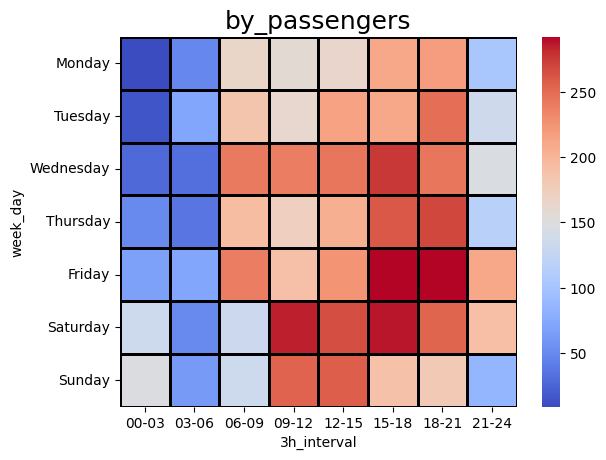

In [72]:
general_dataframe = (df.pipe(add_week_day)
 .pipe(get_time_groups)
 .pipe(group_by_time_weekdays)
 .pipe(calculate_passengers_fare_index)
 )
visualisation_main(general_dataframe, by = 'passengers', visual=True)

In [105]:
visualisation_main(general_dataframe, by = 'passengers', visual=False)


3h_interval,00-03,03-06,06-09,09-12,12-15,15-18,18-21,21-24
week_day,,,,,,,,
Monday,9,48,165,158,164,211,218,104
Tuesday,15,71,185,162,215,211,248,136
Wednesday,28,32,242,239,244,276,244,147
Thursday,50,36,193,173,205,260,269,116
Friday,67,72,240,190,225,292,291,211
Saturday,135,51,132,285,266,287,254,191
Sunday,148,63,134,255,257,189,181,86


Hypotesis: Passengers leave more tips when paying in cash than by card